<a href="https://colab.research.google.com/github/PietroVolpato/lfn_project/blob/main/src/LFN_project_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning from networks project
### Evaluation of different Node Embedding algorithms
Members:<br>
- D'Emilio Filippo, id : 2120931
- Volpato Pietro, id : 2120825

### Introduction to the project
 ---- to do ----


### Required installations:


!pip install node2vec<br>
!pip install requests

### Imports

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import gzip
import urllib.request
import requests
import sys


### Loading the graphs
Adjust the paths of the graphs according to where are stored on your pc.
- Facebook_combined:   https://snap.stanford.edu/data/ego-Facebook.html            4k , 80k
- cit-Helpth           https://networkrepository.com/cit-HepTh.php                 23k , 2.7M
- bio-CE-CX            https://networkrepository.com/bio-CE-CX.php                 15k , 246k

In [18]:
facebook_path = 'facebook_combined.txt.gz' # commentala non cancellarla
cit_path = 'cit-HepTh.edges'
biological_path = 'bio-CE-CX.edges'

In [36]:
G_facebook = nx.Graph()

filename = 'facebook_combined.txt.gz'
with gzip.open(facebook_path, 'rt') as f:
    for line in f:
        node1, node2 = map(int, line.strip().split())
        G_facebook.add_edge(node1, node2)
G_facebook = nx.convert_node_labels_to_integers(G_facebook)  # relabeling nodes to integer
print(f"Facebook graph: |V|={len(G_facebook.nodes)}, |E|={len(G_facebook.edges)}")

G_citation = nx.Graph()

with open(cit_path, 'r') as f:
    for line in f:     # data in this file is formatted differently
        if line.startswith('%'): # Skip comment lines
            continue
        # Split the line and extract the first two columns (nodes)
        data = line.strip().split()
        node1, node2 = int(data[0]), int(data[1])
        G_citation.add_edge(node1, node2)
G_citation = nx.convert_node_labels_to_integers(G_citation)  # relabeling nodes to integer
print(f"citation graph: |V|={len(G_citation.nodes)}, |E|={len(G_citation.edges)}")

G_biological = nx.Graph()
with open(biological_path, 'rt') as f:
    for line in f:
        data = line.strip().split()
        node1, node2 = int(data[0]), int(data[1])
        G_biological.add_edge(node1, node2)
G_biological = nx.convert_node_labels_to_integers(G_biological)  # relabeling nodes to integer
print(f"biological graph: |V|={len(G_biological.nodes)}, |E|={len(G_biological.edges)}")

Facebook graph: |V|=4039, |E|=88234
citation graph: |V|=22908, |E|=2444798
biological graph: |V|=15229, |E|=245952


Spiegazione sui parametri di node2vec:<br>
- G (required): The graph on which to run Node2Vec. Must be an undirected networkx.Graph object.
- dimensions (default = 128): The dimensionality of the node embeddings. Higher dimensions allow for capturing more information but increase computational cost.
- walk_length (default = 80): The number of steps for each random walk. A larger walk_length captures more of the network structure.
- num_walks (default = 10): The number of random walks to start per node. Increasing this can improve the representation at the cost of additional computation.
- workers (default = 1): The number of CPU cores to use for parallel processing. If you're running this on a multi-core machine, increasing this can speed up the computation.
- p (return parameter): p<1: Increases the likelihood of revisiting a node (DFS-like behavior). p>1: Discourages revisiting nodes, encouraging exploration (BFS-like behavior).
- q (in-out parameter): q<1: Encourages walks to nodes further away from the starting node (BFS-like).q>1: Biases walks to nodes closer to the starting node (DFS-like).

Spiegazione di : model = node2vec.fit(window=5, min_count=1, batch_words=4)<br>
This trains a Word2Vec model (from the gensim library) using the random walks. Let’s go over the parameters:<br>

- window (default = 10): The maximum distance between the current and predicted nodes in the random walk sequence. Larger windows capture more context but require more computation.

- min_count (default = 1): Minimum frequency for a node to be considered in the embedding. Since most graphs are sparse, this is often set to 1.

- batch_words (default = 4): The number of words (or nodes) processed in each training batch. Adjust this for performance depending on your hardware.

In [30]:
def reconstruction_error(G, embeddings):
    # Adjacency matrix of the original graph
    A = nx.to_numpy_array(G)

    # Compute similarity matrix from embeddings
    embedding_vectors = np.array([embeddings[node] for node in G.nodes])
    similarity_matrix = cosine_similarity(embedding_vectors)

    # Normalize similarity matrix to match adjacency scale
    similarity_matrix = (similarity_matrix - similarity_matrix.min()) / (
        similarity_matrix.max() - similarity_matrix.min()
    )

    # Compute reconstruction error (MSE)
    mse = mean_squared_error(A.flatten(), similarity_matrix.flatten())
    return mse

# Node2Vec

In [ ]:
def get_node2vec_embeddings(G, dimensions=128, walk_length=10, num_walks=20, p=1, q=1, workers=1):
  node2vec = Node2Vec(G, dimensions, walk_length, num_walks, p, q, workers)
  model = node2vec.fit(window=10, min_count=1, batch_words=4)
  embeddings = {node: model.wv[node] for node in G.nodes}
  return embeddings

In [ ]:
embeddings_facebook_node2vec = get_node2vec_embeddings(G_facebook)
#embeddings_citation_node2vec = get_node2vec_embeddings(G_citation)
embeddings_biological_node2vec = get_node2vec_embeddings(G_biological)

print(f"Reconstruction error facebook graph: {reconstruction_error(G_facebook, embeddings_facebook_node2vec)}")
print(f"Reconstruction error biplocial graph: {reconstruction_error(G_biological, embeddings_biological_node2vec)}")

# GraphWave
how to use:
- git clone https://github.com/snap-stanford/graphwave.git
- modify the sys.path to where_you_cloned_the_repo/graphwave
- Correct the few python 2 wrong sintax lines

In [ ]:
# adjust the path to the directory containing graphwave.py
sys.path.append(r'C:\Users\oppil\OneDrive\Desktop\Universita\magistrale\2_1\LFN\graphwave_pkg\graphwave')
# Import graphwave.py as a module
import graphwave

def get_graphwave_embeddings(G, time_pnts = np.linspace(0, 10, 50), order = 30):
    chi, heat_print, taus = graphwave.graphwave_alg(G, time_pnts, verbose=True, order)
    return chi

In [ ]:
time_pnts = np.linspace(0, 10, 50)
embeddings_facebook_graphwave = get_graphwave_embeddings(G_facebook)
emveddings_biological_graphwave = get_graphwave_embeddings(G_biologica)

#### show the embedding in 2D with PCA
This function can be used for any embedding

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_PCA(embeddings, title = "Visualization in 2D of the embeddings"):
    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], s=10)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# LINE : Large-scale information network embedding
installation guide:
- git clone https://github.com/VahidooX/LINE.git
- !pip install keras
- !pip install tensorflow
- adjust the sys.path to where you downloaded line repository

*NOTE*: it was necessary to modify utils.py to adapt it at current version of keras. Some elements were deprecated

In [28]:
sys.path.append(r'C:\Users\oppil\OneDrive\Desktop\Universita\magistrale\2_1\LFN\LINE')

from model import create_model
from utils import batchgen_train

def get_LINE_embeddings(G, embedding_dim=128, batch_size=1024, negative_ratio=5, epochs=5, negative_sampling="UNIFORM"):
    """
    Generate LINE embeddings for a given graph.

    Parameters:
        G (nx.Graph): The graph for which embeddings are computed.
        embedding_dim (int): Dimensionality of the embeddings.
        batch_size (int): Batch size for training.
        negative_ratio (int): Ratio of negative to positive samples.
        epochs (int): Number of training epochs.
        negative_sampling (str): Negative sampling strategy ("UNIFORM" or "NON-UNIFORM").

    Returns:
        numpy.ndarray: Node embeddings (shape: [num_nodes, embedding_dim]).
    """
    # Number of nodes in the graph
    num_nodes = G.number_of_nodes()

    # Convert networkx.Graph to adj_list (edge list as 2D numpy array)
    adj_list = np.array(list(G.edges()), dtype=np.int32)

    # Create LINE model
    model, embed_generator = create_model(num_nodes, embedding_dim)

    # Generate training batches
    train_gen = batchgen_train(adj_list, num_nodes, batch_size, negative_ratio, negative_sampling)

    # Compile and train the model
    model.compile(optimizer="adam", loss="binary_crossentropy")
    model.fit(train_gen, steps_per_epoch=500, epochs=epochs)

    # Extract embeddings
    node_ids = np.arange(num_nodes)  # Sequential node IDs
    embeddings = embed_generator.predict_on_batch(node_ids)

    print("Node Embeddings Shape:", embeddings[0].shape)
    return embeddings

In [34]:
embeddings_facebook_LINE = get_LINE_embeddings(G_facebook)
print(f"Reconstruction error from matrix A: {reconstruction_error(G_facebook, embeddings_facebook_LINE)}")

Epoch 1/5
500/500 [==============================] - 58s 115ms/step - loss: 0.9843
Epoch 2/5
500/500 [==============================] - 55s 110ms/step - loss: 0.4283
Epoch 3/5
500/500 [==============================] - 57s 114ms/step - loss: 0.3147
Epoch 4/5
500/500 [==============================] - 57s 115ms/step - loss: 0.2438
Epoch 5/5
500/500 [==============================] - 59s 119ms/step - loss: 0.2008
Node Embeddings Shape: (128,)
Reconstruction error from matrix A: 0.10895058732466407


In [37]:
embeddings_citation_LINE = get_LINE_embeddings(G_citation)
print(f"Reconstruction error from matrix A: {reconstruction_error(G_citation, embeddings_citation_LINE)}")

Epoch 1/5
500/500 [==============================] - 74s 148ms/step - loss: 1.0423
Epoch 2/5
500/500 [==============================] - 71s 142ms/step - loss: 0.6887
Epoch 3/5
500/500 [==============================] - 69s 138ms/step - loss: 0.7314
Epoch 4/5
500/500 [==============================] - 69s 137ms/step - loss: 0.9174
Epoch 5/5
500/500 [==============================] - 70s 139ms/step - loss: 0.9625
Node Embeddings Shape: (128,)
Reconstruction error from matrix A: 0.22349057777769538


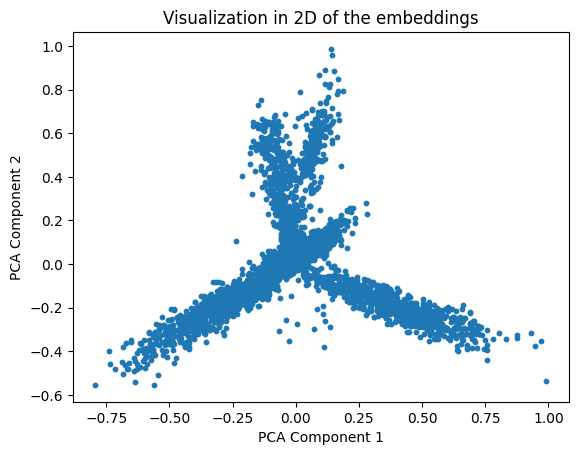

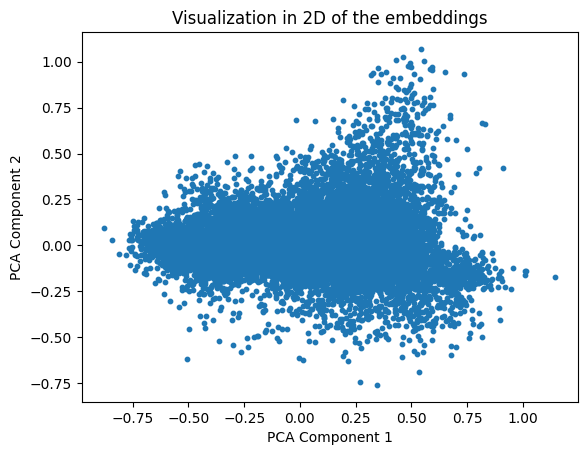

In [41]:
plot_PCA(embeddings_facebook_LINE)
plot_PCA(embeddings_citation_LINE)